In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import statsmodels.formula.api as sm
import json

## Loading the Kafka Events

First we load the energy-update-requests themselves...

In [10]:
f1 = open("../../../../cloud_prod.energy-update-request.log")
raw_update_requests = []
for line in f1:
  try:
    record = json.loads(line)
    raw_update_requests.append(record)
  except json.JSONDecodeError as e:
    pass

kafka_update_requests = pd.DataFrame(raw_update_requests)
kafka_update_requests["message_ts"] = pd.to_datetime(kafka_update_requests["message_ts"])
kafka_update_requests[0:6]

,message_id,message_ts,site_id
0,3a7f9543-41a5-47f0-94f3-084a251ccb70,2017-08-09 04:11:03.278050,69ead6f6-a168-4425-bd2c-65badc14ac7c
1,17e7e112-40d0-4d7f-8eac-872246b92d97,2017-08-09 04:11:06.623812,790d0607-0bc0-42dc-99be-6d4e638331a0
2,e7cc7e5b-6415-4721-8103-3d2288a109d0,2017-08-09 04:11:13.345382,934970df-c376-4408-827f-b0157743fe5e
3,9e1a866d-5b23-4615-85be-dd3c4aae8ac1,2017-08-09 04:11:16.763243,b18370d5-80cd-4f68-b8a3-3974918af287
4,5c8da0d8-3bee-40cb-abad-3d8f04047bfc,2017-08-09 04:11:20.256327,0217766d-16d2-49f9-ac9c-010b70b61d06
5,d0552bb6-ce8c-49b1-83fe-d58ca7432f5d,2017-08-09 04:11:23.742342,b6bb7e04-d9a7-4e29-bac6-d8b66b7a1e69


## Loading the Log Events

Next we load the `efc.worker.energy_update_request.progress` records which the system generated as a response to receiving the kafka events. We will filter the log events to those at [line 88 of worker_energy_update_request.py](https://github.com/TheDataGuild/agl-p2p-config/blob/253d984ae7b62f03b1a2299e90245e070e450319/src/aglp2p/energy_flow_control/worker_energy_update_request.py#L88)

In [11]:
f2 = open("../../../../cloud_prod.energy-update-events.log")
raw_update_events = []
for line in f2:
  try:
    record = json.loads(line)
    if record["@fields"]["message"] == "Looking up current energy flow for site":
      raw_update_events.append(record)
  except (json.JSONDecodeError, KeyError) as e:
    pass

temp_update_events = []
for record in raw_update_events:
  try:
    record = \
      {
        "timestamp": record["@timestamp"], 
        "message_id": record["@fields"]["data"]["message_id"], 
        "message_ts": record["@fields"]["data"]["message_ts"] 
      }
    temp_update_events.append(record)
  except json.JSONDecodeError as e:
    pass

update_events = pd.DataFrame(temp_update_events)
update_events["message_ts"] = pd.to_datetime(update_events["message_ts"])
update_events["timestamp"] = pd.to_datetime(update_events["timestamp"])
update_events[0:6]

,message_id,message_ts,timestamp
0,d803c7a7-3dc0-476f-b0e1-917e2b9d490e,2017-08-08 08:21:11.822702,2017-08-08 08:21:11.871807
1,731f4adf-951b-4433-86dc-9c42edf61997,2017-08-08 08:21:15.239646,2017-08-08 08:21:15.292129
2,e7a92850-9d09-4283-8b53-ac442eeddb2c,2017-08-08 08:21:18.553576,2017-08-08 08:21:18.604537
3,67fbe266-a6e9-463f-8e3e-fd8eb4f1f548,2017-08-08 08:21:21.869719,2017-08-08 08:21:21.922211
4,68cf955f-9495-40ad-bea3-8171a10b7bc0,2017-08-08 08:21:25.247374,2017-08-08 08:21:25.302719
5,d0975486-585f-4712-b303-88a7b9e9c3fb,2017-08-08 08:21:29.226462,2017-08-08 08:21:29.278133


## Time Between Log Events

Next we will look at the time that occurred between log events...

In [12]:
last = pd.to_datetime(np.nan)
def elapsed(row):
    global last
    diff = (row.message_ts - last).total_seconds()
    last = row.message_ts
    return diff

update_events["log_message_pause"] = update_events.apply(elapsed,axis=1)
update_events.set_index("message_ts", inplace=True)
update_events = update_events[1:]
update_events[0:10]

,message_id,timestamp,log_message_pause
message_ts,,,
2017-08-08 08:21:15.239646,731f4adf-951b-4433-86dc-9c42edf61997,2017-08-08 08:21:15.292129,3.416944
2017-08-08 08:21:18.553576,e7a92850-9d09-4283-8b53-ac442eeddb2c,2017-08-08 08:21:18.604537,3.313930
2017-08-08 08:21:21.869719,67fbe266-a6e9-463f-8e3e-fd8eb4f1f548,2017-08-08 08:21:21.922211,3.316143
2017-08-08 08:21:25.247374,68cf955f-9495-40ad-bea3-8171a10b7bc0,2017-08-08 08:21:25.302719,3.377655
2017-08-08 08:21:29.226462,d0975486-585f-4712-b303-88a7b9e9c3fb,2017-08-08 08:21:29.278133,3.979088
2017-08-08 08:21:59.257464,591f68c9-e965-4b41-8cf6-723477bd4ee6,2017-08-08 08:21:59.314249,30.031002
2017-08-08 08:21:59.368598,fea44861-a6f8-4be8-9363-ef866d5ef9e3,2017-08-08 08:21:59.415660,0.111134
2017-08-08 08:22:02.182201,5651c526-6de9-4f4e-b050-683eab15fe2b,2017-08-08 08:22:02.235185,2.813603
2017-08-08 08:22:02.290520,180d3bca-6561-4585-831c-4642165f39df,2017-08-08 08:22:02.342685,0.108319


## Visualizing Gaps

Now we will look at the gaps where no messages were sent for a while...

In [13]:
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

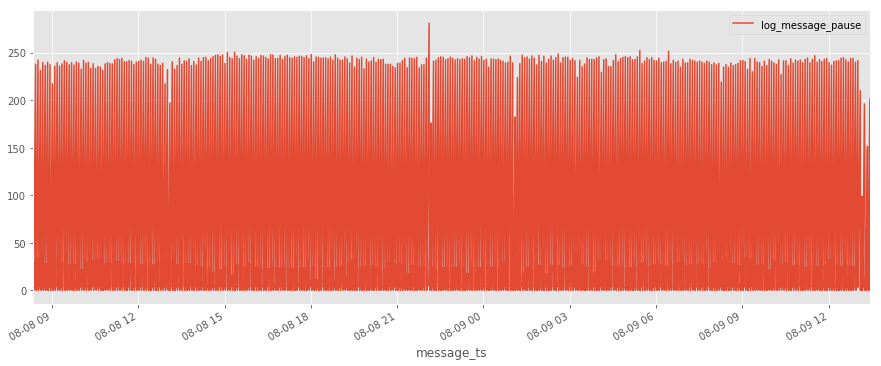

In [14]:
update_events.plot()

## Time Between Kafka Events

Now lets look at the time between Kafka events...

In [15]:
kafka_update_requests["kafka_message_pause"] = kafka_update_requests.apply(elapsed,axis=1)
kafka_update_requests.set_index("message_ts", inplace=True)
kafka_update_requests[0:20]
kafka_update_requests = kafka_update_requests[1:]

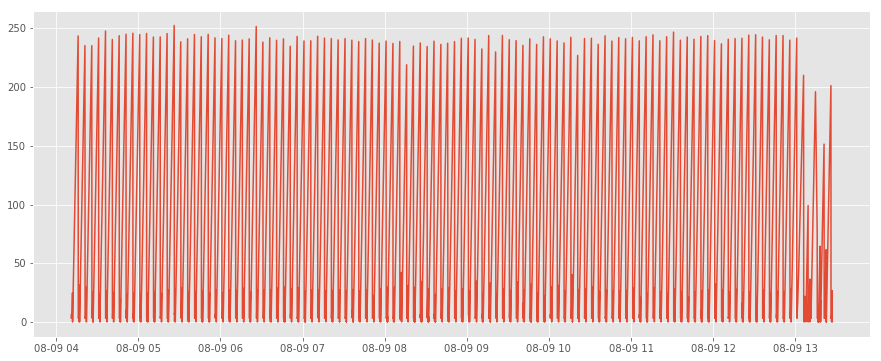

In [16]:
plt.plot(kafka_update_requests.index, kafka_update_requests.kafka_message_pause)
plt.show()

## Zooming In
Lets zoom in on both for the period of `2017-08-09T07` through `2017-08-09T08` and plot both series next to one another...

/Users/rjurney/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


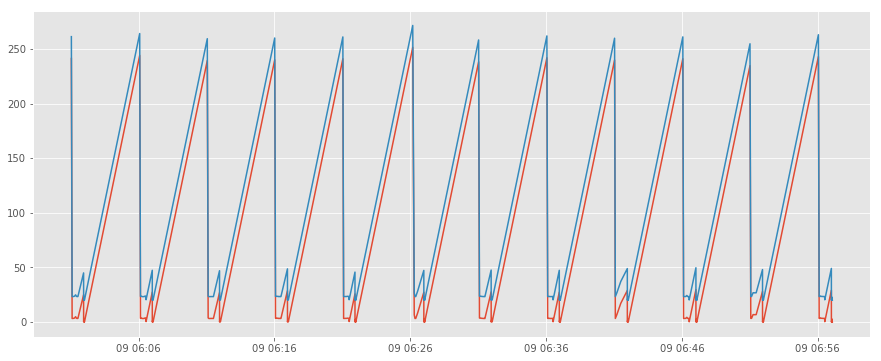

In [17]:
zoom_update_events = update_events.loc["2017-08-09 06:00:00":"2017-08-09 07:00:00"]
zoom_kafka_requests = kafka_update_requests.loc["2017-08-09 06:00:00":"2017-08-09 07:00:00"]
zoom_kafka_requests["kafka_message_pause"] = zoom_kafka_requests["kafka_message_pause"] + 20

plt.plot(zoom_update_events.index, zoom_update_events.log_message_pause)
plt.plot(zoom_kafka_requests.index, zoom_kafka_requests.kafka_message_pause)
plt.show()

## Zooming Out

Now lets zoom back out and plot the difference between these two time series overall. To do that we need to reindex to something like every five minutes, so the datasets match.

In [18]:
print(len(update_events))
print(len(kafka_update_requests))

5283
1699


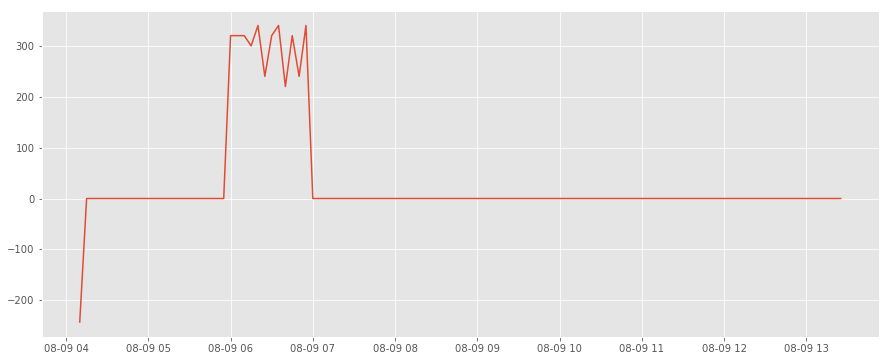

In [19]:
five_minute_update_events = update_events.log_message_pause.resample("5T").sum()
five_minute_kafka_requests = kafka_update_requests.kafka_message_pause.resample("5T").sum()
combined_five_minutes = pd.concat([five_minute_update_events, five_minute_kafka_requests], axis=1, join='inner')

combined_five_minutes["pause_difference"] = combined_five_minutes["kafka_message_pause"] - combined_five_minutes["log_message_pause"]
plt.plot(combined_five_minutes.index, combined_five_minutes.pause_difference)

## Zooming in Again

It looks like lots of differences appear at `2017-08-09 06:00:00` to `2017-08-09 07:00:00`...

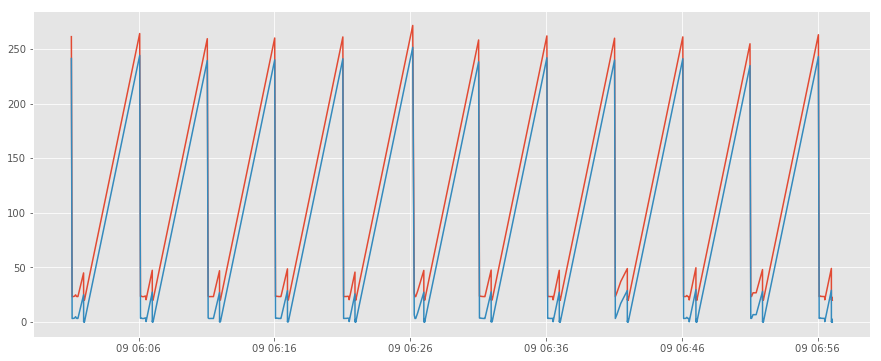

In [20]:
rough_kafka_requests = kafka_update_requests.loc["2017-08-09 06:00:00":"2017-08-09 07:00:00"]
rough_log_events = update_events.loc["2017-08-09 06:00:00":"2017-08-09 07:00:00"]

plt.plot(rough_kafka_requests.index, rough_kafka_requests.kafka_message_pause)
plt.plot(rough_log_events.index, rough_log_events.log_message_pause)
plt.show()

/Users/rjurney/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/rjurney/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


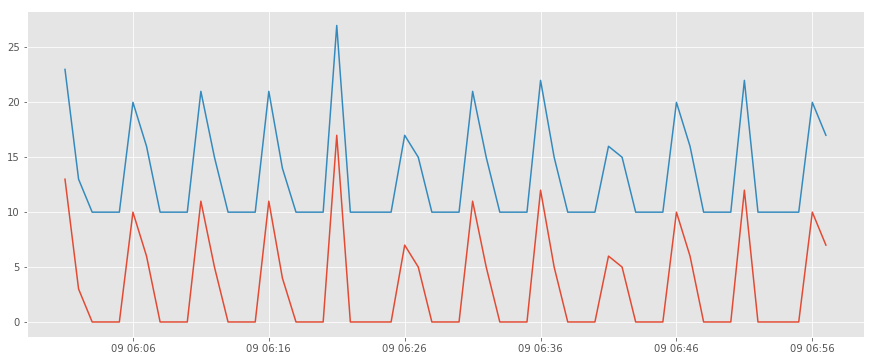

In [21]:
rough_kafka_requests["kafka_count"] = 1
one_minute_kafka_requests = rough_kafka_requests.kafka_count.resample("1T").sum().fillna(0)
rough_log_events["log_count"] = 1
one_minute_log_events = rough_log_events.log_count.resample("1T").sum().fillna(0)

plt.plot(one_minute_kafka_requests.index, one_minute_kafka_requests)
plt.plot(one_minute_log_events.index, one_minute_log_events + 10)
plt.show()

## Sending End

This analysis is incomplete without the sending log events. Next we load those.

In [50]:
f3 = open("../../../../cloud_prod.sent_messages.log")
raw_sent_messages = []
for line in f3:
  try:
    record = json.loads(line)
    json_data = record["@fields"]["data"]
    data = json.loads(json_data)
    processed_record = {"message_ts": data["message_ts"], "message_id": data["message_id"]}
    raw_sent_messages.append(processed_record)
  except (KeyError, json.JSONDecodeError) as e:
    pass

sent_messages = pd.DataFrame(raw_sent_messages)
sent_messages["message_ts"] = pd.to_datetime(sent_messages["message_ts"])
sent_messages.set_index("message_ts", inplace=True)
sent_messages = sent_messages[1:]
sent_messages[0:6]

,message_id
message_ts,
2017-08-08 08:21:15.239646,731f4adf-951b-4433-86dc-9c42edf61997
2017-08-08 08:21:18.553576,e7a92850-9d09-4283-8b53-ac442eeddb2c
2017-08-08 08:21:21.869719,67fbe266-a6e9-463f-8e3e-fd8eb4f1f548
2017-08-08 08:21:25.247374,68cf955f-9495-40ad-bea3-8171a10b7bc0
2017-08-08 08:21:28.593667,d5e04675-14a8-4f7c-9ffd-30c448332a5e
2017-08-08 08:21:29.226462,d0975486-585f-4712-b303-88a7b9e9c3fb


## Sent and Received Message Counts

Now lets look at the sent and received messages per minute...

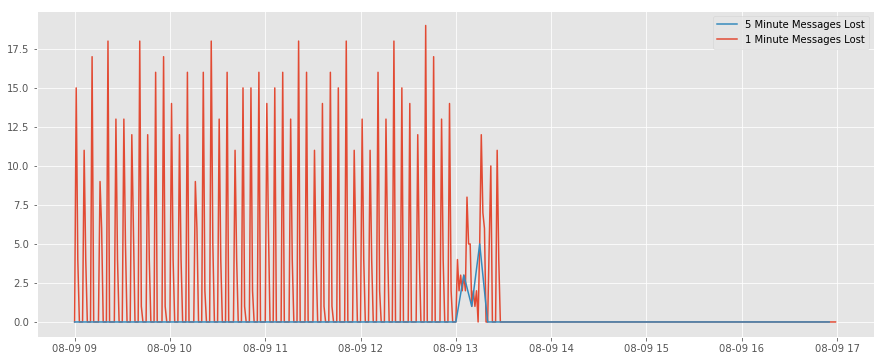

In [121]:
# Reindex sent messages to one minute/sum the sent_count
sent_messages["sent_count"] = 1
one_minute_sent_messages = sent_messages.sent_count.resample("1T").sum().fillna(0)

# Recreate kafka requests
kafka_update_requests["kafka_count"] = 1
one_minute_kafka_requests = kafka_update_requests.kafka_count.resample("1T").sum().fillna(0)

# Zoom in on one period both datasets share
zoom_one_minute_kafka = one_minute_kafka_requests.loc["2017-08-09 09:00:00":"2017-08-09 17:00:00"]
zoom_one_minute_sent = one_minute_sent_messages.loc["2017-08-09 09:00:00":"2017-08-09 17:00:00"]

# Now reindex to fill holes
date_index = pd.date_range('2017-08-09 09:00:00', periods=480, freq='1T')
filled_kafka_messages = zoom_one_minute_kafka.reindex(date_index, fill_value=0.0)
filled_sent_messages = zoom_one_minute_sent.reindex(date_index, fill_value=0.0)

diff_sent_receive = abs(filled_kafka_messages - filled_sent_messages)
diff_sent_receive

# Draw a chart
import matplotlib.patches as mpatches
lost_line, = plt.plot(diff_sent_receive.index, diff_sent_receive, label="1 Minute Messages Lost")

# Now re-index on 5 minutes, to see if messages were just delayed
date_index = pd.date_range('2017-08-09 09:00:00', periods=96, freq='5T')
filled_kafka_messages = zoom_one_minute_kafka.reindex(date_index, fill_value=0.0)
filled_sent_messages = zoom_one_minute_sent.reindex(date_index, fill_value=0.0)

diff_sent_receive = abs(filled_kafka_messages - filled_sent_messages)

five_min_lost_line, = plt.plot(diff_sent_receive.index, diff_sent_receive, label="5 Minute Messages Lost")
plt.legend(handles=[five_min_lost_line, lost_line])
plt.show()


## Conclusion

Many records are taking longer than 1 minute to process, and some are being lost or are taking more than 5 minutes to process.